# Data Pipeline

## Breweries
* Remove observations with '`NA`'
* Remove observations with Brewery Score of `0`
* Convert numeric values to `float`
* Convert categorical columns
    * Convert `Brewery_Type` to four new columns containing booleans for:
        * `Bar`
        * `Eatery`
        * `Homebrew`
        * `Beer-to-go`
* Create boolean from notes column indicating whether Brewery has notes
* Drop unnecessary columns
    * `Brewery_Notes`
    * `Brewery_Type`
    * `Brewery_Class`
    * `pDev` - this is the percent deviation of the scores i.e. results from the score and cannot be used as a predictor.
    
## Beers



## Desired Columns:
* Average score by beer
* Average Alcohol content of beers
* Standard deviation of alcohol content
* Counts by type of beer
* Percentage of beers by beer style
* Region / state / city
* Number of styles produced by a brewery
* Total number of beers
* Average number of beers by style (only counting styles that have at least one beer)
* Create boolean based on whether 'Notes' for each brewery exists
* Create boolean for each beer whether notes exists.
    * Possibly convert to percentage of beers that have notes
    * Could also have total beers with notes (boolean probably better)


Scrape without subpage


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
os.chdir('Data2/')

# Breweries

In [3]:
brews_df = pd.read_pickle('breweries_with_loc')
brews_df.reset_index(inplace=True)
brews_df.columns = ['Brewery_Name','Score', 'Brewery_Class', 'Num_Beers', 
                    'Town', 'State', 'Country', 'Total_Beer_Reviews', 
                    'Total_Beer_Ratings', 'Brewery_Score', 
                    'Num_Brewery_Reviews', 'Num_Brewery_Ratings', 
                    'pDev', 'Brewery_Type', 'Has_Phone', 'Brewery_Notes']

##### Looking at our data

``` python 
i = 0 
while i < 15:
    print(brews_df.iloc[:,i].value_counts())
    i += 1 
    ```

### Removing rows with `'NA'` values

This reduces the number of entries from ????? to 8630. Close to a 50% reduction. While it is unfortunate to lose such a significant portion of a dataset, **all????** of the observations that were removed did not contain a Brewery Score and thus would help in neither training nor testing of the model.

Convert to `'NA'` to `np.nan` 

In [4]:
brews_df.replace('NA',np.nan,inplace=True)
brews_df.dropna(inplace=True)

### Removing rows with Score of zero

In addition to removing Breweries with no score, we've also removed Breweries with a score of zero as they were a clear outlier within the distribution. I believe that Breweries which have yet to receive any reviews either had no value ('NA') or a value of zero. This reduced the total number of Breweries in the dataset to 8153.

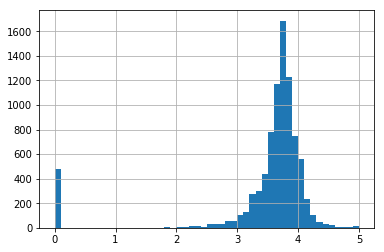

In [5]:
brews_df['Score'] = brews_df['Score'].apply(float)
brews_df['Score'].hist(bins = 50);

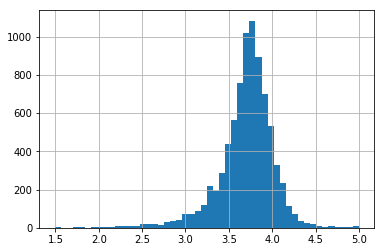

In [6]:
brews_df.replace(0,np.nan,inplace=True)
brews_df.dropna(inplace=True)
brews_df['Score'].hist(bins = 50);

### Convert remaining values to numeric where applicable

In [7]:
i = 0 
while i < 15:
    try:
        brews_df.iloc[:,i] = brews_df.iloc[:,i].apply(float)
    except:
        continue
    i += 1

### Convert Categorical Columns

##### Convert b_type (Brewery Type) to dummies

The assumption in converting Brewery Type to dummies is that the functionality of the brewery, meaning whether one can eat there (i.e. is it also a restaurant) whether they have a bar, etc., may correlate to their score. It is also possible that the particular functionality might be irrelevant and that simply having greater functionality may boost the score (or even reduce it). In such a case we could take the sum of the newly created `'Bar'`, `'Eatery'`, `'Homebrew'`, and `'Beer-to-go'` columns.  
Note that we do not use `.get_dummies()` as it is possible for a brewery to be both a bar, eatery, etc. 

In [8]:
brews_df['Bar'] = brews_df.Brewery_Type.str.contains('Bar')
brews_df['Eatery'] = brews_df.Brewery_Type.str.contains('Eatery')
brews_df['Homebrew'] = brews_df.Brewery_Type.str.contains('Homebrew')
brews_df['Beer-to-go'] = brews_df.Brewery_Type.str.contains('Beer-to-go')

Creating a column containing a boolean value indicating whether a Brewery has notes on their brewery page within Beer Advocate. I believe this may have an impact on a Brewery's score as people may go onto a Brewery's page to research. Some Breweries may indicate hours (or days) of operation. Having a description can help reduce potential points of friction in a customer's relationship with a Brewery thus leading to the customer giving the Brewery a higher score.

In [9]:
brews_df['Has_Notes'] = brews_df.Brewery_Notes.str.contains('No notes at this time.')
brews_df.drop(['Brewery_Notes','Brewery_Type','Brewery_Class','pDev'],inplace=True,axis=1)

Note that we'll leave the Brewery_Name column for now as it will be used to join the beer data with the brewery data.

In [10]:
brews_df.head()

,Brewery_Name,Score,Num_Beers,Town,State,Country,Total_Beer_Reviews,Total_Beer_Ratings,Brewery_Score,Num_Brewery_Reviews,Num_Brewery_Ratings,Has_Phone,Bar,Eatery,Homebrew,Beer-to-go,Has_Notes
0,Guinness Ltd.,3.45,48.0,Dublin,Ireland,Ireland,8736.0,29518.0,3.92,2.0,6.0,0.0,True,True,False,True,True
2,Ballast Point Brewing Company,3.91,175.0,San Diego,California,United States,14500.0,66988.0,4.34,70.0,405.0,1.0,True,False,False,False,False
3,Left Hand Brewing Company,3.78,70.0,Longmont,Colorado,United States,7749.0,26500.0,4.25,47.0,179.0,1.0,True,False,False,True,True
6,Pike Brewing Company,3.68,46.0,Seattle,Washington,United States,1722.0,3761.0,3.89,107.0,197.0,1.0,True,True,False,True,True
7,Brouwerij De Dolle Brouwers,4.17,9.0,Esen,Belgium,Belgium,2525.0,4849.0,4.47,15.0,26.0,1.0,True,True,False,False,False


# Beers

The below was used to open all folders 

``` python
data_fols = os.listdir()

style_nums = []

for fol in data_fols:
    try:
        int(fol)
        style_nums.append(str(fol))
    except:
        pass

beers_df = pd.DataFrame(columns = ['beer_name','brewery_name','abv',
                             'ratings','score','brewery_nums'])

for num in style_nums:
    pickled = pd.read_pickle(num)
    beers_df = pd.concat([beers_df,pickled],sort=True)
    
beers_df.columns = ['ABV','Beer_Name','Brewery_Name',
                    'Brewery_Num','Num_Beer_Ratings',
                    'Beer_Score','Beer_Style']
    
pd.to_pickle(beers_df,'Beer_Data')

```

In [9]:
beers_df = pd.read_pickle('Beer_Data')

get_dummies() of the beer style (keep all columns) and then groupby by brewery and take the sum.

In [10]:
beers_df.head()

,ABV,Beer_Name,Brewery_Name,Brewery_Num,Num_Beer_Ratings,Beer_Score,Beer_Style
0,7.50,Guinness Foreign Extra Stout,Guinness Ltd.,209,"2,468",4.06,Foreign / Export Stout
1,8.80,Lion Stout,Ceylon / Lion Brewery Limited,389,"1,655",3.91,Foreign / Export Stout
2,7.00,Indra Kunindra,Ballast Point Brewing Company,199,"1,285",3.67,Foreign / Export Stout
3,8.50,Fade To Black - Volume 1,Left Hand Brewing Company,418,"1,023",4.08,Foreign / Export Stout
4,6.30,Best Extra Stout,Coopers Brewery Limited,491,691,3.84,Foreign / Export Stout


In [31]:
beers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252588 entries, 0 to 38
Data columns (total 7 columns):
abv             252588 non-null object
beer_name       252588 non-null object
brewery_name    252588 non-null object
brewery_nums    252588 non-null object
ratings         252588 non-null object
score           252588 non-null object
style           252588 non-null object
dtypes: object(7)
memory usage: 15.4+ MB
